In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K
from PIL import Image, ImageDraw, ImageOps
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Constants

In [2]:
IMG_SIZE = (512, 512) #(1024,1024)
BATCH_SIZE = 4

Organizing images and mask files

In [3]:
def build_data(PATH):
    data = []
    filenames = sorted(listdir(PATH))
    for name in filenames:
        data.append(PATH + '/' + name)
    return data

TRAIN_PATH = os.path.join(os.getcwd(),'Roads_dataset\images')
LABEL_PATH_TRAIN = os.path.join(os.getcwd(),'Roads_dataset\labels')

TEST_PATH = './Massachusetts_dataset/tiff/test'
LABEL_PATH_TEST = './Massachusetts_dataset/tiff/test_labels'
VAL_PATH = './Massachusetts_dataset/tiff/val'
LABEL_PATH_VAL = './Massachusetts_dataset/tiff/val_labels'

sat_image = build_data(TRAIN_PATH)
mask_train = build_data(LABEL_PATH_TRAIN)

test_image = build_data(TEST_PATH)
mask_test = build_data(LABEL_PATH_TEST)

Make pandas dataframe out of file addresses

In [4]:
df_train = pd.DataFrame({
    'Image' : sat_image,
    'Mask' : mask_train
})

"df_test = pd.DataFrame({\n    'Image' : test_image,\n    'Mask' : mask_test\n})"

In [5]:
len(sat_image), len(mask_train)


(3579, 3579)

In [ ]:
ds_size = len(sat_image)

In [6]:
df_train

,Image,Mask
0,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
1,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
2,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
3,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
4,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
...,...,...
3574,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
3575,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
3576,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...
3577,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...,f:\UNIVERSITY\GUAP\CV\lab1\roads_processing\Ro...


Transformations definition for more stable recognition

In [5]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 4, p = 0.3), 
    A.ShiftScaleRotate(scale_limit=0, rotate_limit=50, shift_limit=0, p=0.5, border_mode=0),
])

Cutting images into patches of initially defined size

In [ ]:
def cut_into_patches_both_train(img, mask, patch_size=IMG_SIZE):
    img_patches = []
    mask_patches = []
    img = img/255.0
    img = img.astype(np.float64)
    mask = mask.astype(np.float64)
    for y in range(0, img.shape[0], patch_size[1]):
        for x in range(0, img.shape[1], patch_size[0]):
            img_patch = img[y:y + patch_size[1], x:x + patch_size[0]]
            mask_patch = mask[y:y + patch_size[1], x:x + patch_size[0]]
            transformed = transform(image=img_patch, mask=mask_patch)
            img_patch = transformed['image']
            mask_patch = transformed['mask']
            img_patches.append(img_patch)
            mask_patches.append(mask_patch)
    return img_patches, mask_patches

In [ ]:
def cut_into_patches_both_test(img, mask, patch_size=IMG_SIZE):
    img_patches = []
    mask_patches = []
    img = img/255.0
    img = img.astype(np.float64)
    mask = mask.astype(np.float64)
    for y in range(0, img.shape[0], patch_size[1]):
        for x in range(0, img.shape[1], patch_size[0]):
            img_patch = img[y:y + patch_size[1], x:x + patch_size[0]]
            mask_patch = mask[y:y + patch_size[1], x:x + patch_size[0]]
            img_patches.append(img_patch)
            mask_patches.append(mask_patch)
    return img_patches, mask_patches

Making borders with empty pixels to make image be dividable by patch size for preventing losing some image data while cutting into patches

In [ ]:
def create_borders(image_path, desired_size=IMG_SIZE):
    img = Image.open(image_path)
    delta_w = img.size[0] if img.size[0]%desired_size[0]==0 else ((img.size[0]//desired_size[0])+1)*desired_size[0]
    delta_h = img.size[1] if img.size[1]%desired_size[1]==0 else ((img.size[1]//desired_size[1])+1)*desired_size[1]
    padding = (0, 0, delta_w - img.size[0], delta_h- img.size[1])
    img =ImageOps.expand(img, padding)
    return np.array(img)

Processing images and masks

In [ ]:
def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function_train(img, mask):
    img = create_borders(img)
    mask = create_borders(mask)
    mask = modify_mask(mask)
    img, mask = cut_into_patches_both_train(img, mask)

    return img, mask

Creating dataset

In [ ]:
def create_dataset(train):
    train_dataset = tf.data.Dataset.from_tensor_slices((train['Image'], train['Mask']))
    train_dataset = train_dataset.shuffle(4000)
    train_dataset = train_dataset.map(lambda img, mask : tf.numpy_function(
                    map_function_train, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    
    return train_dataset

In [ ]:
train_dataset = create_dataset(df_train)#, test_dataset, df_test
train_img, train_mask = next(iter(train_dataset))

Splitting dataset to train, test and validation sets

In [ ]:
train_split=0.8
val_split=0.15
test_split=0.5
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)

train_ds = train_dataset.take(train_size)    
val_ds = train_dataset.skip(train_size).take(val_size)
test_ds = train_dataset.skip(train_size).skip(val_size)

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

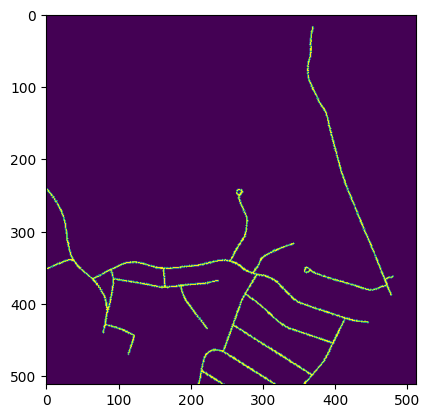

In [11]:
plt.imshow(train_mask[0])

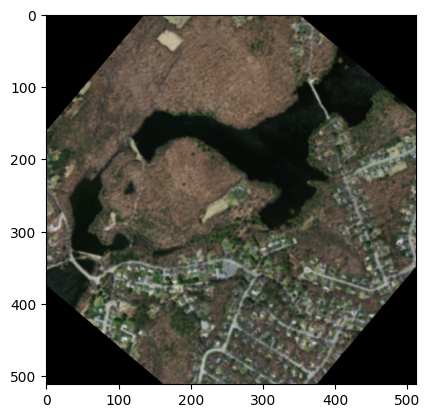

In [12]:
plt.imshow(train_img[0])

Defining metrics for model

In [10]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice_loss = dice_coef_loss(y_true, y_pred)
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce_loss + 0.5 * dice_loss

In [11]:
LR = 0.0002
EPOCHS = 120
optim = keras.optimizers.Adam(LR)
metrics=[dice_coef, sm.metrics.iou_score]

Defining model

In [16]:
import tensorflow as tf
from keras import layers, models, mixed_precision

def ImprovedTernausNet(input_shape=(512, 512, 3), num_classes=1):
    # Enable mixed precision training
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

    # Load pre-trained EfficientNetB4 model without the top layers
    base_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder layers
    encoder1 = base_model.get_layer('block2a_expand_activation')
    encoder2 = base_model.get_layer('block3a_expand_activation')
    encoder3 = base_model.get_layer('block4a_expand_activation')
    encoder4 = base_model.get_layer('block5a_expand_activation')
    encoder5 = base_model.get_layer('block6a_expand_activation')

    # Center block
    center = layers.Conv2D(512, (3, 3), padding='same')(encoder5.output)
    center = layers.BatchNormalization()(center)
    center = layers.LeakyReLU()(center)
    center = layers.Conv2D(512, (3, 3), padding='same')(center)
    center = layers.BatchNormalization()(center)
    center = layers.LeakyReLU()(center)
    center = layers.Dropout(0.5)(center)

    # Decoder layers
    decoder4 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(center)
    upsample4 = layers.UpSampling2D((2, 2))(encoder4.output)
    decoder4 = layers.concatenate([decoder4, upsample4])
    decoder4 = layers.Conv2D(256, (3, 3), padding='same')(decoder4)
    decoder4 = layers.BatchNormalization()(decoder4)
    decoder4 = layers.LeakyReLU()(decoder4)
    decoder4 = layers.Conv2D(256, (3, 3), padding='same')(decoder4)
    decoder4 = layers.BatchNormalization()(decoder4)
    decoder4 = layers.LeakyReLU()(decoder4)

    decoder3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(decoder4)
    upsample3 = layers.UpSampling2D((2, 2))(encoder3.output)
    decoder3 = layers.concatenate([decoder3, upsample3])
    decoder3 = layers.Conv2D(128, (3, 3), padding='same')(decoder3)
    decoder3 = layers.BatchNormalization()(decoder3)
    decoder3 = layers.LeakyReLU()(decoder3)
    decoder3 = layers.Conv2D(128, (3, 3), padding='same')(decoder3)
    decoder3 = layers.BatchNormalization()(decoder3)
    decoder3 = layers.LeakyReLU()(decoder3)

    decoder2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(decoder3)
    upsample2 = layers.UpSampling2D((2, 2))(encoder2.output)
    decoder2 = layers.concatenate([decoder2, upsample2])
    decoder2 = layers.Conv2D(64, (3, 3), padding='same')(decoder2)
    decoder2 = layers.BatchNormalization()(decoder2)
    decoder2 = layers.LeakyReLU()(decoder2)
    decoder2 = layers.Conv2D(64, (3, 3), padding='same')(decoder2)
    decoder2 = layers.BatchNormalization()(decoder2)
    decoder2 = layers.LeakyReLU()(decoder2)

    decoder1 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(decoder2)
    upsample1 = layers.UpSampling2D((2, 2))(encoder1.output)
    decoder1 = layers.concatenate([decoder1, upsample1])
    decoder1 = layers.Conv2D(32, (3, 3), padding='same')(decoder1)
    decoder1 = layers.BatchNormalization()(decoder1)
    decoder1 = layers.LeakyReLU()(decoder1)
    decoder1 = layers.Conv2D(32, (3, 3), padding='same')(decoder1)
    decoder1 = layers.BatchNormalization()(decoder1)
    decoder1 = layers.LeakyReLU()(decoder1)

    # Output layer
    output = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder1)

    # Create the improved TernausNet model
    model = models.Model(inputs=base_model.input, outputs=output)

    return model

model = ImprovedTernausNet()

Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  DML, no compute capability (probably not an Nvidia GPU) (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [17]:
model.compile(optim, combined_loss, metrics)

Defining callbacks, saving best model and reducing learning rate while training stuck on the same loss

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_ternaus.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-9, verbose=1),
]
model.optimizer.lr.assign(2e-4)

Check if training on gpu is available and prevent memory from overflowing after training

In [ ]:
print(tf.config.list_physical_devices('GPU')) 

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Training model

In [29]:
# train model
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_ds, 
)

Epoch 1/120
716/716 [==============================] - 465s 637ms/step - loss: 0.4382 - dice_coef: 0.3292 - iou_score: 0.2047 - val_loss: 0.5762 - val_dice_coef: 0.0845 - val_iou_score: 0.0456 - lr: 2.0000e-04
Epoch 2/120
716/716 [==============================] - 453s 631ms/step - loss: 0.3239 - dice_coef: 0.4983 - iou_score: 0.3348 - val_loss: 0.3097 - val_dice_coef: 0.5158 - val_iou_score: 0.3508 - lr: 2.0000e-04
Epoch 3/120
716/716 [==============================] - 450s 628ms/step - loss: 0.3025 - dice_coef: 0.5343 - iou_score: 0.3672 - val_loss: 0.2880 - val_dice_coef: 0.5540 - val_iou_score: 0.3862 - lr: 2.0000e-04
Epoch 4/120
716/716 [==============================] - 446s 622ms/step - loss: 0.2908 - dice_coef: 0.5528 - iou_score: 0.3848 - val_loss: 0.2852 - val_dice_coef: 0.5554 - val_iou_score: 0.3880 - lr: 2.0000e-04
Epoch 5/120
716/716 [==============================] - 443s 617ms/step - loss: 0.2828 - dice_coef: 0.5660 - iou_score: 0.3977 - val_loss: 0.2704 - val_dice_coef

Training statistics

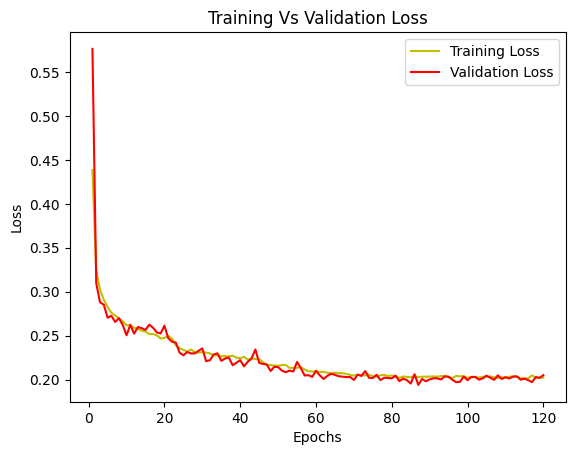

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

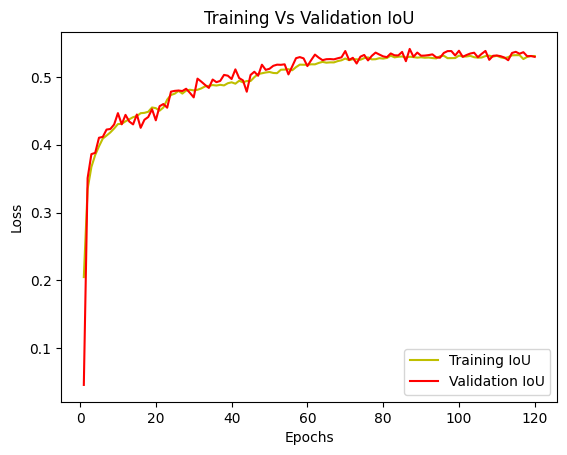

In [32]:
jaccard_coef = history.history['iou_score']
val_jaccard_coef = history.history['val_iou_score']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Model evaluation on test set

In [33]:
score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20348656177520752
Test accuracy: 0.6930459141731262


In [30]:
model.save(f'road_segmentation_120epochs.h5')